# 8. Introduction to NLP (Natural Language Processing) in TensorFlow Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

%matplotlib inline

In [2]:
!nvidia-smi

Fri Jul 15 00:30:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8     5W /  N/A |     76MiB /  6144MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Read in the data
train_df = pd.read_csv('../Data/NLP/train.csv')
test_df = pd.read_csv('../Data/NLP/test.csv')

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df['text'].to_numpy(), train_df['target'].to_numpy(), test_size=0.1, random_state = 42)

In [8]:
pd.Series(train_labels).value_counts()/pd.Series(train_labels).value_counts().sum()

0    0.571595
1    0.428405
dtype: float64

In [9]:
train_df.target.value_counts()/train_df.target.value_counts().sum()

0    0.57034
1    0.42966
Name: target, dtype: float64

Great! The distribution is virtually the same which means we can proceed towards the training.

In [12]:
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix, calculate_results, unzip_data

### 1. Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API.

In [16]:
MAX_TOKENS = 10000
LENGTH_OF_SEQUENCE = 15

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_TOKENS, output_sequence_length = LENGTH_OF_SEQUENCE, pad_to_max_tokens = True, name = "text_vectorisation_layer")
text_vectorizer.adapt(train_sentences)

model_1 = tf.keras.Sequential(
    [
        text_vectorizer,
        tf.keras.layers.Embedding(input_dim = MAX_TOKENS, output_dim = 128, input_length = LENGTH_OF_SEQUENCE, name = "embedding_layer"),
        tf.keras.layers.GlobalMaxPool1D(name = "global_max_pooling_layer"),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_1_sequential"
)

In [17]:
model_1.summary()

Model: "model_1_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorisation_layer (T  (None, 15)               0         
 extVectorization)                                               
                                                                 
 embedding_layer (Embedding)  (None, 15, 128)          1280000   
                                                                 
 global_max_pooling_layer (G  (None, 128)              0         
 lobalMaxPooling1D)                                              
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [18]:
SAVE_DIR = "TensorBoard/NLP"

In [19]:
# Compile the model
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_1 = model_1.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_1_dense_sequential")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_1_dense_sequential/20220715-010544
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.6378 - accuracy: 0.6627 - val_loss: 0.5756 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4699 - accuracy: 0.8260 - val_loss: 0.4855 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3406 - accuracy: 0.8755 - val_loss: 0.4739 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2579 - accuracy: 0.9075 - val_loss: 0.4827 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1976 - accuracy: 0.9323 - val_loss: 0.4996 - val_accuracy: 0.7953


In [20]:
model_1_results = calculate_results(val_labels, tf.squeeze(tf.round(model_1.predict(val_sentences))))
model_1_results

24/24 [==============================] - 0s 7ms/step


{'accuracy': 79.52755905511812,
 'precision': 0.7960291067316854,
 'recall': 0.7952755905511811,
 'f1': 0.7933872033947167}

And that sorts out model_1.

In [21]:
model_2 = tf.keras.Sequential(
    [
        text_vectorizer,
        tf.keras.layers.Embedding(input_dim = MAX_TOKENS, output_dim = 128, input_length = LENGTH_OF_SEQUENCE, name = "embedding_layer"),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_2"
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorisation_layer (T  (None, 15)               0         
 extVectorization)                                               
                                                                 
 embedding_layer (Embedding)  (None, 15, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_2 = model_2.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_2_lstm_sequential")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_2_lstm_sequential/20220715-011530
Epoch 1/5
215/215 [==============================] - 19s 13ms/step - loss: 0.5103 - accuracy: 0.7460 - val_loss: 0.4697 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3078 - accuracy: 0.8707 - val_loss: 0.4919 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2094 - accuracy: 0.9216 - val_loss: 0.6366 - val_accuracy: 0.7336
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1423 - accuracy: 0.9482 - val_loss: 0.8412 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0995 - accuracy: 0.9609 - val_loss: 0.8809 - val_accuracy: 0.7428


In [23]:
model_2_results = calculate_results(val_labels, tf.squeeze(tf.round(model_2.predict(val_sentences))))
model_2_results

24/24 [==============================] - 1s 14ms/step


{'accuracy': 74.2782152230971,
 'precision': 0.7418286470789891,
 'recall': 0.7427821522309711,
 'f1': 0.7417868391767628}

Okay. This seems to have worsened performance!

In [32]:
model_5 = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer"),
        text_vectorizer,
        tf.keras.layers.Embedding(input_dim = MAX_TOKENS, output_dim = 128, input_length = LENGTH_OF_SEQUENCE, name = "embedding_layer"),
        tf.keras.layers.Conv1D(64, 5, padding = "valid", activation = "relu", name = "conv_layer"),
        tf.keras.layers.GlobalMaxPool1D(name = "max_pooling_1d_layer"),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_5"
)

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorisation_layer (T  (None, 15)               0         
 extVectorization)                                               
                                                                 
 embedding_layer (Embedding)  (None, 15, 128)          1280000   
                                                                 
 conv_layer (Conv1D)         (None, 11, 64)            41024     
                                                                 
 max_pooling_1d_layer (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 1,321,089
Trainable params: 1,321,089
Non-tra

In [33]:
# Compile the model
model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_5 = model_5.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_conv1d_sequential")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_5_conv1d_sequential/20220715-013201
Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.5515 - accuracy: 0.7167 - val_loss: 0.4801 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3286 - accuracy: 0.8643 - val_loss: 0.5201 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2020 - accuracy: 0.9283 - val_loss: 0.6178 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1274 - accuracy: 0.9575 - val_loss: 0.6954 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0941 - accuracy: 0.9696 - val_loss: 0.7473 - val_accuracy: 0.7546


In [34]:
model_5_preds = tf.squeeze(tf.round(model_5.predict(val_sentences)))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 75.45931758530183,
 'precision': 0.7542507437514857,
 'recall': 0.7545931758530183,
 'f1': 0.7543892493889404}

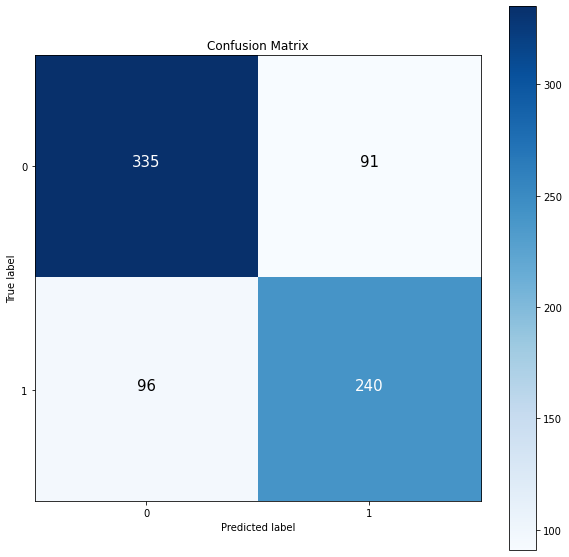

In [35]:
make_confusion_matrix(val_labels, model_5_preds)